# Handfan Reviews

![Olele](img/olele.jpg)
$^{1}$Image credit: https://olele.es/

{octicon}`calendar` Feb, 2023

{bdg-primary-line}`Web Scraping` {bdg-primary-line}`Sentiment Analysis`

## Background
My wife crafts hand fans and sells them online under the brand name **Olelé**. Her catchphrase is: *Spanish hand fans with a different touch*. She basically sells them on [Etsy](https://www.etsy.com/shop/Olele) and ships them out to the whole world.

She started in 2010 and has received many reviews ever since. I suggested doing a little analysis on them. "I'd like that", she said. Of course, she knew the majority of the reviews were very positive, so she had no problem showing them off.

She said: "Let me see if I can remember how to download the reviews in a file from my Etsy account". "Don't worry", I replied, "I'm going to scrape them directly from the website!"

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import Markdown

# Web scraping
import requests
from bs4 import BeautifulSoup

# Sentiment
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

## Web scraping the data
On the Etsy website I saw that Olelé's reviews were placed along 28 different pages. I could access them changing URL query parameters, so I programmed some lines to automate the fetching of HTML pages and extraction of the desired data from them: `name`, `date`, `stars` and review `text`.

![Etsy](img/olele-etsy.png)

In [2]:
# Params
pages = 28 # Review pages present for Olele
wait_time = 180 # seconds
attempts = 3 # max attempts

# Init
page = 1
attempt = 0
names_dates = []
stars = []
texts = []

# Iterate through pages
while page <= pages:

    # Update page number in query parameters of the URL
    url = f"https://www.etsy.com/shop/Olele/reviews?ref=pagination&page={page}"
    
    # Request data
    r = requests.get(url)
    
    # Server answers 'Too many requests'
    if r.status_code == 429:
        attempt += 1
        print(f"Waiting {wait_time}s in attempt {attempt}")
        time.sleep(wait_time) # Wait!
        if attempt >= attempts:
            raise Exception (f"Server still answering '429' after {attempt-1} attempts")
            break
            
    # Something went wrong      
    elif r.status_code != requests.codes.ok: # Not 200
        raise Exception (f"requests.get(url) returns {r.status_code}")
        break
        
    # Ok, go on!
    else:
        attempt = 0
        print(f"Scraping review page {page}...")
        
        # Get content
        html = r.content
        
        # Parse
        soup = BeautifulSoup(html)
        
        # Search for the data
        for review in soup.find_all('div', attrs={'class':'review-item'}):
            
            # Extract name and date
            name_date = review.find('p', attrs={'class':'shop2-review-attribution'})
            if name_date is None: # Didn't find anything
                dates.append('')
            else:
                name_date = name_date.get_text(strip=True)
                names_dates.append(name_date)
                
            # Extract stars
            star = review.find('span', attrs={'class':'screen-reader-only'})
            if star is None: # Didn't find anything
                stars.append('')
            else:
                star = star.get_text(strip=True)
                stars.append(star)

            # Extract review text
            text = review.find('p', attrs={'class':"prose wt-break-word wt-m-xs-0"})
            if text is None: # Didn't find anything
                texts.append('')
            else:
                text = text.get_text(strip=True)
                texts.append(text)
        
        page += 1
        if page > pages:
            print("Scraping finished!")

# Store listed reviews in a dataframe dropping duplicates
olele = pd.DataFrame({"name_date": names_dates, "stars": stars, "text": texts})\
                    .drop_duplicates()
olele

Scraping review page 1...
Scraping review page 2...
Scraping review page 3...
Scraping review page 4...
Scraping review page 5...
Scraping review page 6...
Scraping review page 7...
Scraping review page 8...
Scraping review page 9...
Scraping review page 10...
Scraping review page 11...
Scraping review page 12...
Scraping review page 13...
Scraping review page 14...
Scraping review page 15...
Scraping review page 16...
Scraping review page 17...
Scraping review page 18...
Scraping review page 19...
Scraping review page 20...
Scraping review page 21...
Scraping review page 22...
Scraping review page 23...
Scraping review page 24...
Waiting 180s in attempt 1
Scraping review page 25...
Scraping review page 26...
Scraping review page 27...
Scraping review page 28...
Scraping finished!


,name_date,stars,text
0,"Carolinaon Nov 1, 2022",5 out of 5 stars,As usual the quality is sturdy yet elegant and...
1,"Amy Annetteon Sep 3, 2022",5 out of 5 stars,I bought this fan to bring to tango and swing ...
2,"Maryon Aug 31, 2022",5 out of 5 stars,LOVELY! I think this is my 4th fan? Complimen...
3,"Eni Aon Aug 31, 2022",5 out of 5 stars,"Very beautiful fan, great quality and the colo..."
4,"hredmondson Jun 11, 2022",5 out of 5 stars,This is the second fan I've bought for myself ...
...,...,...,...
272,"Anonymous on Jun 21, 2010",5 out of 5 stars,Thank you!
273,"Anonymous on Jun 18, 2010",5 out of 5 stars,Gorgeous! Love it! Just in time for the summer...
274,"Anonymous on Jun 15, 2010",5 out of 5 stars,Really nice communication with Karmele Luqui. ...
275,"Anonymous on Jun 12, 2010",5 out of 5 stars,A huge WOW when I just got them! The fans are ...


## Data processing
The acquired data needed some processing before proceeding with the analysis:
- Split `name_date` column into two different columns, `name` and `date`.
- Convert `date` column from string to `datetime` data type.
- Extract stars as an integer number from the string type `stars` column.
- Rearrange the whole pandas dataframe: desired columns, names, order, index.
- Finally, fill in missing (NaN) values in `text` with empty strings.

In [3]:
# Split name and date in different columns
olele[["name", "date"]] = olele["name_date"].str.split(pat="on ", expand=True)

# Convert date column to datetime type
olele["datetime"] = pd.to_datetime(olele["date"])

# Convert stars column from string to number
olele["stars_n"] = [stars[0] for stars in olele["stars"]]
olele["stars_n"] = olele["stars_n"].astype(str).astype(int)

# Rearrange dataframe with columns name, date, stars, text
olele = olele.iloc[:, [3, 5, 6, 2]]
olele = olele.rename(columns={"datetime": "date", "stars_n": "stars"})
olele = olele.set_index("date")

# Replace missing values
olele = olele.fillna("")

# Show dataframe info
print(olele.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 2022-11-01 to 2010-06-10
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    265 non-null    object
 1   stars   265 non-null    int32 
 2   text    265 non-null    object
dtypes: int32(1), object(2)
memory usage: 7.2+ KB
None


In [4]:
olele

,name,stars,text
date,,,
2022-11-01,Carolina,5,As usual the quality is sturdy yet elegant and...
2022-09-03,Amy Annette,5,I bought this fan to bring to tango and swing ...
2022-08-31,Mary,5,LOVELY! I think this is my 4th fan? Complimen...
2022-08-31,Eni A,5,"Very beautiful fan, great quality and the colo..."
2022-06-11,hredmonds,5,This is the second fan I've bought for myself ...
...,...,...,...
2010-06-21,Anonymous,5,Thank you!
2010-06-18,Anonymous,5,Gorgeous! Love it! Just in time for the summer...
2010-06-15,Anonymous,5,Really nice communication with Karmele Luqui. ...


The dataframe is now ready for analysis.

## Data analysis

### Number of reviews per year

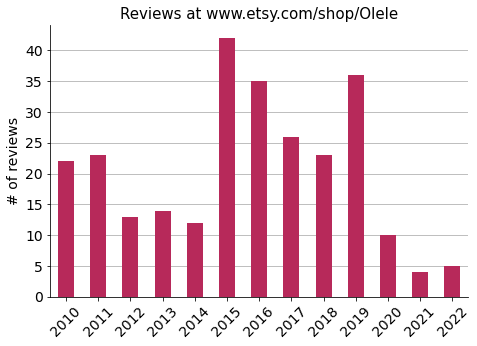

In [5]:
# Count reviews per year
reviews_yearly = olele.groupby(olele.index.year)["name"].count()

# Plot
color_olele = ["#b7295a"] # From olele color palette

fig, ax = plt.subplots(figsize=(7.5, 5))

reviews_yearly.plot(ax=ax, kind="bar", color=color_olele)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Reviews at www.etsy.com/shop/Olele", size=15)
ax.set_xlabel("")
ax.set_ylabel("# of reviews", size=14)
sns.despine()

plt.show()

After some successful years, it looks like reviews have decreased lately.

### Average number of reviews per month

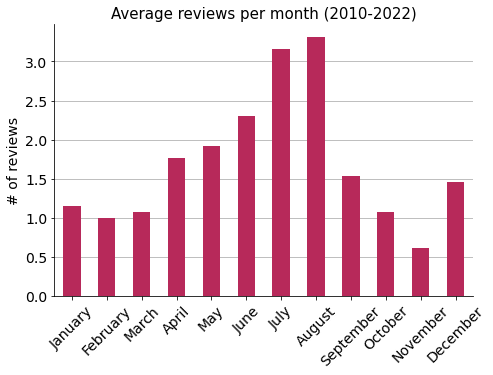

In [6]:
# Compute number of years
nbr_years = len(olele.index.year.unique())

# Calculate monthly average
reviews_monthly_avg = olele.groupby(olele.index.month)["name"].count() / nbr_years

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

reviews_monthly_avg.plot(ax=ax, kind="bar", color=color_olele)

months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.set_xticklabels(months, rotation=45)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Average reviews per month (2010-2022)", size=15)
ax.set_xlabel("")
ax.set_ylabel("# of reviews", size=14)
sns.despine()

plt.show()


It shows a seasonality that matches the increased number of hand fans that are sold in the summer.

### Stars' distribution

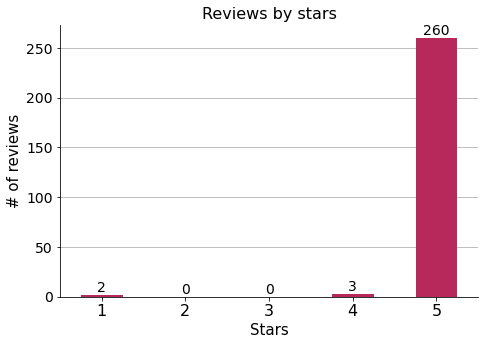

In [7]:
# Count stars
stars_count = olele["stars"].value_counts().to_frame()

# Define a dataframe with all possibilities: 1, 2, 3, 4, 5 stars
frame = pd.DataFrame(index=[1, 2, 3, 4, 5])

# Merge them to build a dataframe ready to plot
stars = frame.merge(stars_count, how="left",
                    left_on=frame.index, right_on=stars_count.index)
stars = stars.set_index("key_0").fillna(0).astype(int)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

stars.plot(ax=ax, kind="bar", color=color_olele)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=16, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Reviews by stars", size=16)
ax.set_xlabel("Stars", size=15)
ax.set_ylabel("# of reviews", size=15)
ax.bar_label(ax.containers[0], size=14)
ax.legend().set_visible(False)
sns.despine()

plt.show()

Overwhelming majority of 5-star reviews!

### Top reviewers

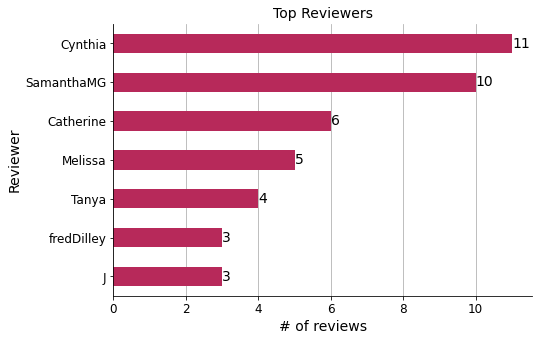

In [8]:
# Top reviewers
reviewers = olele.value_counts("name")
reviewers_top = reviewers[1:8] # 3 reviews or more

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

reviewers_top.sort_values().plot(ax=ax, kind="barh", color=color_olele)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("Top Reviewers", size=14)
ax.set_xlabel("# of reviews", fontsize=14)
ax.set_ylabel("Reviewer", fontsize=14)
ax.bar_label(ax.containers[0], size=14)
sns.despine()

plt.show()

According to my wife, most of these top reviewers are customers from the US.

### Longest review

Out of curiosity, let's have a look into the longest review of all.

In [23]:
# Sort reviews by text length and take the first one
print(olele.loc[olele["text"].str.len().sort_values(ascending=False).index[0]]["text"])

I was looking for the perfect fan for a man like me. Then I found Karmeles shop and this wonderfully beautiful accessory. And I was thrilled with him in a split of a second. Blue is my favorite color and the pattern immediately made me think of a night sky shining with thousands of stars. Bingo! Hit! It had to be! Karmele made the fan very clean and simply perfect. He is delivered in a very nice and fine dark blue leather pocket. So now I can keep him safely at all times. An absolutely perfect combination, in my opinion. I can't wait to use him on a sunny spring day. We had it yesterday, but with 5 degrees and cool wind... I am absolutely certain, that we will have warmer temperatures very soon. Now I wish Karmele continued success and that she and all her loved ones stay healthy. Kind regards, Friedrich


## Sentiment analysis
I am using a Python library called `TextBlob` for processing textual data and get:
1. Information about the emotion contained in the text.
2. The most common words.

### Polarity and subjectivity

We need reviews to include text, so we discard the ones without it.

In [10]:
# Copy to a new dataframe only reviews containing text
olele_texted = olele[olele["text"] != ""].copy()

# Print how many were selected
print(f"{len(olele_texted)} 'texted' reviews out of {len(olele)} were selected.")

235 'texted' reviews out of 265 were selected.


Now, I obtain polarity and subjectivity indexes for each review.

In [11]:
# Init
polarities = []
subjectivities = []

# Iterate through texts getting polarity and subjectivity
for text in olele_texted["text"]:
    blob = TextBlob(text)
    polarities.append(blob.sentiment.polarity)
    subjectivities.append(blob.sentiment.subjectivity)
    
# Create new columns with sentiment info
olele_texted["polarity"] = polarities
olele_texted["subjectivity"] = subjectivities

# Print head of the dataframe
olele_texted.head()

,name,stars,text,polarity,subjectivity
date,,,,,
2022-11-01,Carolina,5,As usual the quality is sturdy yet elegant and...,0.406190,0.759405
2022-09-03,Amy Annette,5,I bought this fan to bring to tango and swing ...,0.435714,0.534127
2022-08-31,Mary,5,LOVELY! I think this is my 4th fan? Complimen...,0.625000,0.750000
2022-08-31,Eni A,5,"Very beautiful fan, great quality and the colo...",0.637500,0.637500
2022-06-11,hredmonds,5,This is the second fan I've bought for myself ...,0.458333,0.416667


- *polarity* index: from "-1" meaning negative emotion, to "1" positive emotion, with "0" being neutral.
- *subjectivity* index: from "0" meaning objective assertion, to "1" being completely subjective.

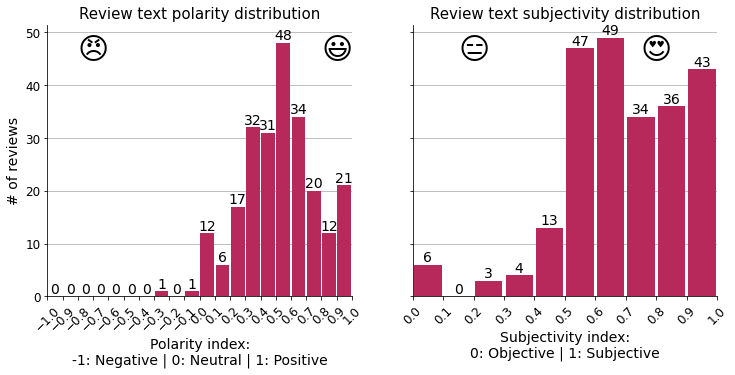

In [12]:
# Plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
sns.despine()

olele_texted["polarity"].plot(ax=ax[0], kind="hist", bins=20, range=(-1, 1),
                           rwidth=0.9, color=color_olele)

olele_texted["subjectivity"].plot(ax=ax[1], kind="hist", bins=20, range=(-1, 1),
                           rwidth=0.9, color=color_olele)

for i in range(2):
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
    ax[i].tick_params(axis='x', labelsize=12, rotation=45)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].set_ylabel("# of reviews", fontsize=14)
    ax[i].bar_label(ax[i].containers[0], size=14)
    ax[i].legend().set_visible(False)
    
ax[0].set_title("Review text polarity distribution", size=15)
ax[0].set_xlabel("Polarity index:\n-1: Negative | 0: Neutral | 1: Positive", fontsize=14)
ax[0].set_xlim(-1, 1)
ax[0].set_xticks(np.arange(-1, 1.1, 0.1))
ax[0].annotate("\U0001F603", (0.8, 45), size=30) # Smiling emoji
ax[0].annotate("\U0001F620", (-0.8, 45), size=30) # Angry emoji

ax[1].set_title("Review text subjectivity distribution", size=15)
ax[1].set_xlabel("Subjectivity index:\n0: Objective | 1: Subjective", fontsize=14)
ax[1].set_xlim(0, 1)
ax[1].set_xticks(np.arange(0, 1.1, 0.1))
ax[1].annotate("\U0001F60D", (0.75, 45), size=30) # In love emoji
ax[1].annotate("\U0001F611", (0.15, 45), size=30) # Neutral emoji

plt.show()

The model calculates the polarity and subjectivity of the texts based on the words they contain, and this is the distribution of the results. We can see that the general mood matches the overwhelming majority of 5 stars rated by the customers.

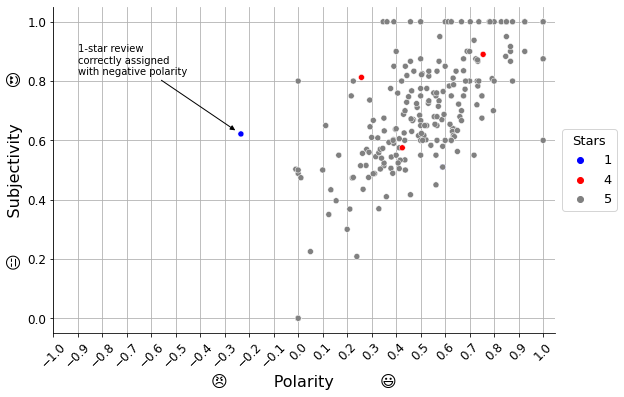

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))

sns.scatterplot(ax=ax, x="polarity", y="subjectivity", data=olele_texted,
               hue="stars", palette=["blue", "red", "grey"] )

ax.grid(axis="both")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("", size=15)
ax.set_xlabel("\U0001F620         Polarity         \U0001F603", fontsize=16)
ax.set_ylabel("\U0001F611       Subjectivity       \U0001F60D", fontsize=16)
ax.set_xlim(-1, 1.05)
ax.set_xticks(np.arange(-1, 1.1, 0.1))
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=13,
          title="Stars", title_fontsize=13)
ax.annotate("1-star review\ncorrectly assigned\nwith negative polarity",
            xy=(-0.25, 0.63), 
            xytext=(-0.9, 0.82),
            arrowprops={"arrowstyle":"-|>", "color":"black"})
sns.despine()

plt.show()

It seems there is a pattern in the scatter plot shown above, a sort of linear relationship between polarity and subjectivity: the more positive the emotion is, the more subjective seems to be according to the algorithm.

#### Bad reviews
It is interesting to see how the model captures at least one of the bad reviews ("1"-star reviews), assigning it the lowest polarity of the set. Let's take a look at it.

In [14]:
# Filter reviews with 1 star
bad_reviews = olele_texted[olele_texted["stars"] == 1]
bad_reviews

,name,stars,text,polarity,subjectivity
date,,,,,
2019-11-19,Sednah,1,Kamele came thought for us and I'm very please...,0.59000,0.510000
2017-04-04,kim,1,I never received this fan I have been in touch...,-0.23375,0.621667


In fact, there are 2 reviews with 1 star. Oddly, one of them (the one by Sednah) has a positive polarity and gets overlapped in the last plot. Let's read the texts to find out what is going on:

In [15]:
for text in bad_reviews["text"]:
    print(text+"\n")

Kamele came thought for us and I'm very pleased to say that she has excellant customer service. The fans are attention grabbing in the best way.  This is my 3rd fan and I will order more when the time comes. It also makes a great holiday gift.

I never received this fan I have been in touch with the supplier and still waiting for it to be resolved either a refund or replacement, very disappointing as it was my  first buy from Etsy !



Clearly, the first one is a positive review (as the algorithm correctly interprets with the positive polarity it assigns), so the 1-star rating was a mistake made by the reviewer.

The second one is indeed a bad review, as both the algorithm and the reviewer tell (according to my wife, the problem with the courier was finally solved).

#### Objective reviews

In [16]:
# Filter reviews with subjectivity index == 0
objective_reviews = olele_texted[olele_texted["subjectivity"] == 0]
objective_reviews

,name,stars,text,polarity,subjectivity
date,,,,,
2019-05-22,Céline,5,It is sublime! Thank you,0.0,0.0
2019-02-04,福島 圭子,5,"I received it, thank you.",0.0,0.0
2017-08-01,adeline,5,A merveillosa réal,0.0,0.0
2015-08-11,Tanya,5,This fan is so well made. Thank you!,0.0,0.0
2010-07-01,Anonymous,5,Thank you!,0.0,0.0
2010-06-21,Anonymous,5,Thank you!,0.0,0.0


The texts are very short here (they all fit in the dataframe preview above). We can conclude that there are not enough words for the algorithm to calculate sentiments, and that is why it assigns zero values to the polarity and subjectivity, making them neutral.

#### Extreme reviews

In [17]:
# Filter reviews with maximum subjectivity and polarity index values
extreme_reviews = olele_texted[(olele_texted["subjectivity"] == 1) \
                               & (olele_texted["polarity"] == 1)]
extreme_reviews

,name,stars,text,polarity,subjectivity
date,,,,,
2019-12-13,Su,5,Very beautiful and so well made. Just what I w...,1.0,1.0
2019-02-17,Amy,5,This is a beautiful fan. Thank you!,1.0,1.0
2018-12-29,adeline,5,Perfect like always,1.0,1.0
2018-06-16,Carla,5,Absolutely a beautiful fan and can’t wait to u...,1.0,1.0
2017-10-14,jenniferpbowman1,5,Absolutely beautiful!,1.0,1.0
2017-10-14,jenniferpbowman1,5,Beautiful!,1.0,1.0
2016-08-13,Robin,5,"Beautiful, thank you !",1.0,1.0
2016-07-06,Sommerlinde,5,"The fan is beautiful, thank you!",1.0,1.0
2016-01-26,Catherine,5,"Perfect, thank you. Very beautiful!",1.0,1.0


In [18]:
for text in extreme_reviews["text"]:
    print(text)

Very beautiful and so well made. Just what I wanted.
This is a beautiful fan. Thank you!
Perfect like always
Absolutely a beautiful fan and can’t wait to use it. Thank you!
Absolutely beautiful!
Beautiful!
Beautiful, thank you !
The fan is beautiful, thank you!
Perfect, thank you. Very beautiful!
Bellisimo! Perfect for spring and summer. Thank you!
The fan is beautiful and well made!
very beautiful and just as pictured
Beautiful!
They're beautiful!  Thank you!


Extreme sentiment values seem to come from short sentences loaded with words with a high sentiment charge, like "beautiful" or "perfect".

### Frequency of words

#### Word cloud
Let's make a word cloud to get an impression of the words that stand out. To do so we have to convert all the reviews into one single text.

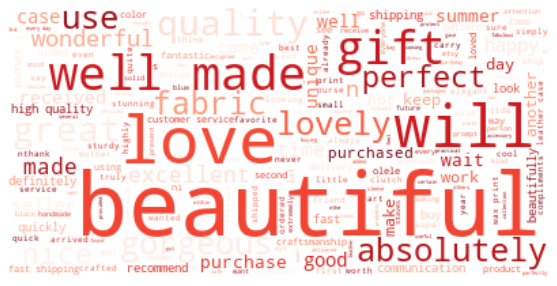

In [22]:
# Get full text and convert it into lowercase to avoid repetitions
full_text = olele_texted.to_string(columns=["text"], index=False).lower()

# Include English stopwords and own ones after several tests
STOPWORDS.update(["karmele", "fan", "fans", "thank", "thanks",
                 "'s", "n't", "'m", "'ve", "much", "one", "many",
                 "really", "hand", "bought"])

# Create word cloud
cloud = WordCloud(background_color="white", colormap="Reds",
                  stopwords=STOPWORDS).generate(full_text)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.imshow(cloud, interpolation='bilinear')
ax.axis('off')

plt.show()

#### Most frequent words
Finally, I will look at the most common words and plot their frequency.

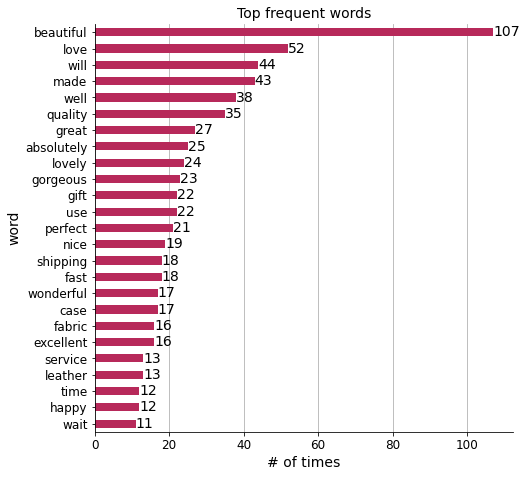

In [20]:
# Tokenize the full text into individual words
all_words = list(TextBlob(full_text).words)

# Do not consider stopwords built previously for the word cloud
words = [word for word in all_words if word not in STOPWORDS]

# Take the most common 25 words
common_words = Counter(words).most_common(25)

# Convert to pandas dataframe
most_common_words = pd.DataFrame(common_words, columns=["word", "n"]).set_index("word")

# Plot
fig, ax = plt.subplots(figsize=(7.5, 7.5))

most_common_words.sort_values("n").plot(ax=ax, kind="barh", color=color_olele)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("Top frequent words", size=14)
ax.set_xlabel("# of times", fontsize=14)
ax.set_ylabel("word", fontsize=14)
ax.bar_label(ax.containers[0], size=14)
ax.legend().set_visible(False)
sns.despine()

plt.show()

In [21]:
display(Markdown(f"The prevalent word in reviews for Olelé is '**{most_common_words.index[0]}**'."))

The prevalent word in reviews for Olelé is '**beautiful**'.

## Conclusions

In this project, customer reviews from an online shop were web-scraped and analysed in their numbers and sentiments. It contains a brief foray into NLP (Natural Language Processing) domain via TextBlob, a library that makes textual data processing really simple.

The reviews for Olelé on Etsy were great, but unfortunately this case was not useful to build a customized interpretative model (a possible the next step in a project like this), because there were not enough bad reviews for a machine learning algorithm to be trained.